

```
The Notebook can be loaded from this link:
https://colab.research.google.com/drive/1Sb2Eqbsr4RViG3A4GR1hpEkba5C-R0a7
```



In [0]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/chengmar09/comp0053.git  

GitHub user··········
GitHub password··········
fatal: destination path 'comp0053' already exists and is not an empty directory.


In [0]:
!echo 'Check Current Dir'
%cd /content/comp0053/
%tensorflow_version 1.x
!pwd && ls
!pip install -r Requirement.txt
!pip install h5py

Check Current Dir
/content/comp0053
TensorFlow 1.x selected.
/content/comp0053
COMP0053_EmoPain_Demo.ipynb  helper.py	  Requirement.txt
data			     __pycache__  Synthetic_Data.ipynb
Feature_Selection.ipynb      README.md	  train.py


In [0]:
pip install wget

In [0]:
pip install tensorflow

In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [0]:
from helper import *
import scipy

movementDataLoader = DataReader('Movementdata') #<- Automatically download data
(train_x, train_y), (valid_x, valid_y) = movementDataLoader.more_more_processing(v_stack=False)

Using TensorFlow backend.


Folder exists
Training zip file exists
Validation zip file exists
Train data already exists
Valid data already exists
There is total of 23 training data
There is total of 12 Validation data


# Visualising the imbalance 

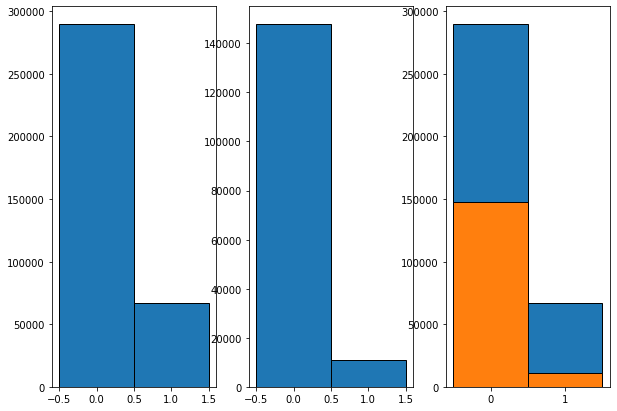

In [0]:
import matplotlib.pyplot as plt

def visualise_imbalance(train_y, valid_y ,labels=[0,1]):

    fig, axes= plt.subplots(nrows=1, ncols=3, figsize = (10,7))
    plt.xticks((0,1))
    axes[0].hist(train_y, label=labels, bins=[-.5,.5,1.5], ec="k")
    axes[1].hist(valid_y, label=labels, bins=[-.5,.5,1.5], ec="k")

    axes[2].hist(train_y, label=labels, bins=[-.5,.5,1.5], ec="k")
    axes[2].hist(valid_y, label=labels, bins=[-.5,.5,1.5], ec="k")

    plt.show()

visualise_imbalance(train_y,valid_y)

Class Imbalance

<br>
Looking at the histogram for Ground Truth, we can see that our dataset is heavily biased towards 0 class. From this we can conlude
that when choosing algorithms to apply to the dataset, we must be wary of choosing ones that are sensitve to class
imbalance, as they may be heavily biased towards the more prevalent class.
This fact also suggests that using a simple metric for evaluating the quality of a model, such as misclassification loss may produce a poor estimate for generalisation loss, as the algorithm may learn to simply always predict the more common class and still obtain high accuracy. <br>

<br>
Finally, given the imbalance of classes in the dataset, when constructing validation sets (or cross-validation folds) for validation if chosen poorly we have a high likelihood of obtaining subsets of only the non-default data, resulting in poor estimates for the true generalisation loss. Hence, this visualization suggests that it might be worthwhile investing in using
stratified techniques when splitting the data for validation.

2D Scatterplot of the imbalance


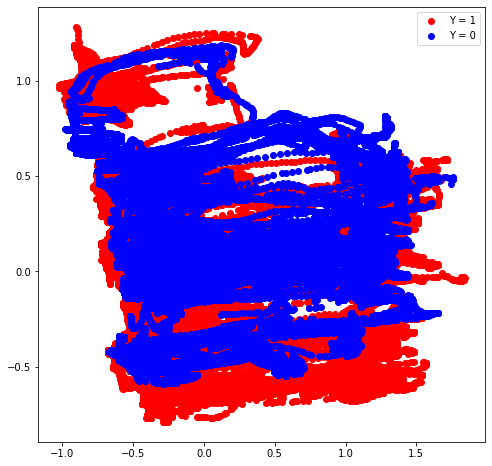

3D Scatterplot of the imbalance


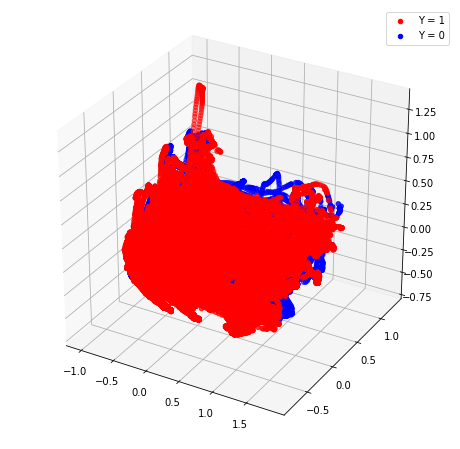

In [0]:
#Dimensionality Reduction imports
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
def transform_and_plot(model, data=train_x, labels=train_y):
    """
    Fits a given model over the scaled dataset and plots the result
    :param model - the untrained model to be fitted over the data
    :param data - the scaled data to be transformed
    :param labels - the corresponding labels for the data
    """

    reduced = model.fit_transform(data)
    dimensions = reduced.shape[1]
    print("{}D Scatterplot of the imbalance".format(dimensions))
    labelled = np.c_[reduced, labels]
    assert dimensions == 2 or dimensions == 3, 'transform only supports 2 or 3 dimensions'
    projection = None
    if dimensions == 3:
        projection = '3d'
    
    figure = plt.figure(figsize=(8,8))
    ax = figure.add_subplot(1,1,1, projection=projection)
    neg = reduced[labelled[:,dimensions] == 0]
    pos = reduced[labelled[:,dimensions] == 1]
    ax.scatter(*(neg[:,i] for i in range(dimensions)), c='r')
    ax.scatter(*(pos[:,i] for i in range(dimensions)), c='b')
    ax.legend(['Y = 1', 'Y = 0'])
    plt.show()
#     time.sleep(10)

transform_and_plot(PCA(n_components=2), train_x, train_y)
transform_and_plot(PCA(n_components=3), train_x, train_y)


# Splitting the training data into different modality

<br>
Split data into (anglees, energy, seng), label


In [0]:
(train_x, train_y), (valid_x, valid_y) = movementDataLoader.get_processed_data()

def create_module(x, y):
    joint_angles=[]
    joint_energies=[]
    seng=[]
    label=[]
    for frame in x:
        for observation in frame:
            joint_angles.append(observation[:13])
            joint_energies.append(observation[13:26])
            seng.append(observation[26:31])
    print(len(joint_angles))

    for frame in y:
        for observation in frame:
            label.append(observation)

    joint_angles=np.array(joint_angles)
    joint_energies = np.array(joint_energies)
    seng=np.array(seng)
    label=np.array(label)

    print(np.unique(label))
    print(joint_angles.shape, joint_energies.shape, seng.shape, label.shape) #correct

    return (joint_angles, joint_energies, seng, label)


train_joint_angles, train_joint_energies, train_seng, train_y = create_module(train_x, train_y)
valid_joint_angles, valid_joint_energies, valid_seng, valid_y = create_module(valid_x, valid_y)

356107
[0. 1.]
(356107, 13) (356107, 13) (356107, 5) (356107, 1)
158438
[0. 1.]
(158438, 13) (158438, 13) (158438, 5) (158438, 1)


In [0]:
def individual_modality(data):
    columns=4
    rows = (np.ceil(data.shape[1]/2/4)).astype(int)
    fig, axs = plt.subplots(rows, columns,figsize=(15,15))
    plt.suptitle('Scatter Plot')
    plt.style.use('ggplot')
    k=0
    if rows >1:
        for i in range(rows):
            for j in range(columns):
                if not j*2+k+1 > data.shape[1]-1:
                    axs[i,j].scatter(data[:,j*2+k], data[:, (j*2)+k+1], edgecolors=['blue','red'], cmap='jet') 
                    continue
            k+= j*2+2
    else:
        for j in range(columns):
            if not j*2+k+1 > data.shape[1]-1:
                axs[j].scatter(data[:,j*2+k], data[:, (j*2)+k+1], edgecolors=['blue','red'], cmap='jet') 
                continue

In [0]:
individual_modality(train_joint_angles)

In [0]:
individual_modality(valid_joint_angles)

In [0]:
print(seng.shape)
individual_modality(train_seng)

In [0]:
individual_modality(valid_seng)

In [0]:
individual_modality(train_joint_energies)

In [0]:
individual_modality(valid_joint_energies)

In [0]:
def pairwise_feature(data, data2):
    columns =4
    min_data = min(data.shape[1], data2.shape[1])
    rows = (np.ceil(min_data/2/4)).astype(int)
    fig, axs = plt.subplots(rows, columns,figsize=(15,15))
    plt.suptitle('Scatter Plot')
    plt.style.use('ggplot')
    k=0
    for i in range(rows):
        for j in range(columns):
            if not j*2+k+1 > min_data-1:
                axs[i,j].scatter(data[:,j*2+k], data2[:, j*2+k], edgecolors=['blue','red'], cmap='jet') 
                continue
        k+= j*2+2
    
pairwise_feature(train_joint_angles, train_joint_energies)
pairwise_feature(valid_joint_angles, valid_joint_energies)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc927b171e0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fc92783d6a8> (for post_execute):


KeyboardInterrupt: ignored

# Feature Selection using PCA

PCA reduces the dimensionality to only the n most important component (n_components = 0.99)

The first graph shows the number of components n we need to take to taken into account for 99% of variance and the scatter plot shows the clustering of the first 2 dimensions  

In [0]:
#Dimensionality Reduction imports
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import matplotlib.pyplot as plt

def plot_cumsum_pca ():
    fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(6,6))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    axs[0].set_title("joint angles")
    axs[1].set_title("joint energies")
    axs[2].set_title("joint angles and energies")
    i = 0 
    for data in [joint_angles, joint_energies, seng]:      # <- Require Scaling!!!!!
        pca = PCA()
        data_pca = pca.fit(data)
        axs[i].plot(np.cumsum(pca.explained_variance_ratio_))
        x_line= np.where(np.cumsum(pca.explained_variance_ratio_)>0.99)[0][1]
        axs[i].axvline(x=x_line, ls='--', c='k')
        i+=1

#plot_cumsum_pca()

In [0]:
def pca_selection(data):
    pca = PCA(n_components =0.99)
    reduced = pca.fit_transform(data)
    print("number of features selected: {}".format(pca.n_components_))
    return reduced

def pca_selection_v2(data):
    pca = PCA(n_components= 7)
    reduced = pca.fit_transform(data)
    print("number of features selected: {}".format(pca.n_components_))
    return reduced

In [0]:
#Remember apply Standard Scalar

#pca_reduced_angles = pca_selection(joint_angles)
#print(pca_reduced_angles.shape)
#individual_modality(pca_reduced_angles)

# Feature Selection using Lasso

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

def lasso_selection(X, y):
    y = np.ravel(y)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='saga'))
    embeded_lr_selector.fit(X, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = embeded_lr_selector.transform(X)
    print('selected features {}'.format(embeded_lr_feature.shape))
    return embeded_lr_feature, embeded_lr_support

In [0]:
#lasso_selected_train_x = lasso_selection(joint_angles, label)
#individual_modality(joint_angles)

# Feature Selection using Random Forest Classifier

random forest has an in-built functionality of choosing the features with highest feature importance score
the value of the n_estimators should be tested

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


def tree_selection(X, y, estimator=30):
    y = np.ravel(y)
    #try 10,30,100
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=estimator))
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
#     print(embeded_rf_support)
    embeded_rf_feature = embeded_rf_selector.transform(X)
#     print(embeded_rf_feature)
    print('selected features {}'.format(embeded_rf_feature.shape))
    return embeded_rf_feature

# for item in [joint_angles, joint_energies, train_x]:
#     for estimator in [10,30,100]:
#         tree_selection(item, train_y, estimator)

In [0]:
#forest_selected_angles = tree_selection(joint_angles, label, 30)
#print(forest_selected_angles.shape)
#individual_modality(forest_selected_angles)

# Feature Selection via Anova


<br>
Statistical tests can be used to select those features that have the strongest relationship with the output variable. The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features. <br>

<br>
Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data. This can be used via the f_classif() function. We will select the 4 best features using this method in the example below.

In [0]:
# load data
(train_x, train_y), _ = movementDataLoader.more_more_processing(v_stack=False)

# Feature Selection with Univariate Statistical Tests
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova(X, y, k=10):
    # feature extraction
    
    test = SelectKBest(score_func=f_classif, k=k)
    fit = test.fit(X, Y)
    # summarize scores
    set_printoptions(precision=3)
    print('Fitting scores : {} \n length: {}'.format(fit.scores_, len(fit.scores_)))
    features = fit.transform(X)
    # summarize selected features
    print(features.shape)
    return features

X = train_x
Y = train_y.squeeze()
anova(X,Y,10)

Fitting scores : [ 526.428 2487.446   35.201  474.808  198.65   250.842  235.885 1028.863
  234.537 1938.149 4700.717 7024.874   58.877  725.637  514.023 1196.037
 1324.352 1065.226  695.219   39.522  209.71    46.532   20.442  754.793
  357.116   35.197] 
 length: 26
(356107, 10)


array([[1.089e+00, 1.022e+00, 6.733e-01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.089e+00, 1.022e+00, 6.733e-01, ..., 1.892e-06, 1.597e-06,
        1.345e-07],
       [1.089e+00, 1.022e+00, 6.728e-01, ..., 5.310e-07, 5.231e-07,
        7.636e-07],
       ...,
       [1.037e+00, 9.521e-01, 1.153e+00, ..., 3.675e-06, 3.561e-06,
        2.828e-07],
       [1.037e+00, 9.527e-01, 1.153e+00, ..., 9.342e-07, 1.759e-06,
        9.641e-07],
       [1.037e+00, 9.534e-01, 1.153e+00, ..., 4.836e-06, 6.600e-06,
        5.681e-06]])

# Analysis OF feature selection on performance 🎵

### Pre-liminary and support function

In [0]:
def custom_training_func(input_tx, input_ty, input_vx, input_vy, epoch=5):
    
    EPOCHS = epoch

    # Change the below
    train_x, train_y = input_tx, input_ty
    valid_x, valid_y = input_vx, input_vy

    import keras
    num_classes = 2
    train_y = keras.utils.to_categorical(train_y, num_classes)
    valid_y = keras.utils.to_categorical(valid_y, num_classes)

    from sklearn.metrics import f1_score

    from keras.models import Sequential, Model, load_model
    from keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, GRU
    from keras.callbacks import ModelCheckpoint

    from helper import f1_m

    model = Sequential()
    model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m])

    # checkpoint
    checkpoint_path = "stack_bilstm.h5"
    #model = load_model(checkpoint_path, custom_objects={'f1_score': f1_score})
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    history = model.fit(train_x, train_y, validation_split=0.1, epochs=EPOCHS, callbacks=callbacks_list)  # starts training

    return model, history

In [0]:
# Some information function: 
'''
Feature Selection Algorithm 

pca_selection <-> input (x)
lasso_selection <-> input(x,y)
tree_selection <-> input(x,y)
anova <-> input(x, y)
'''

'\nFeature Selection Algorithm \n\npca_selection <-> input (x)\nlasso_selection <-> input(x,y)\ntree_selection <-> input(x,y)\nanova <-> input(x, y)\n'

## 1. Use PCA on data to train


### 1.1 Perform Standard Scaling and Principle Componment Analysis on the data

In [0]:
(train_x, train_y), (valid_x, valid_y) = movementDataLoader.get_processed_data()
train_joint_angles, train_joint_energies, train_seng, train_y = create_module(train_x, train_y)
valid_joint_angles, valid_joint_energies, valid_seng, valid_y = create_module(valid_x, valid_y)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

cocat_train_x = np.concatenate((train_joint_angles, train_joint_energies, train_seng), axis=1)
cocat_valid_x = np.concatenate((valid_joint_angles, valid_joint_energies, valid_seng), axis=1)

standard_scaler = StandardScaler()    ## Important -> PCA requires unit variance
cocat_train_x = standard_scaler.fit_transform(cocat_train_x)
cocat_valid_x = standard_scaler.fit_transform(cocat_valid_x)

pca_reduced_train_x = pca_selection(cocat_train_x)
pca_reduced_valid_x = pca_selection(cocat_valid_x)

print(pca_reduced_train_x.shape, pca_reduced_valid_x.shape)

356107
[0. 1.]
(356107, 13) (356107, 13) (356107, 5) (356107, 1)
158438
[0. 1.]
(158438, 13) (158438, 13) (158438, 5) (158438, 1)
number of features selected: 27
number of features selected: 27
(356107, 27) (158438, 27)


### 1.2 Pre-Process Data Before Training

In [0]:
def _shape_changing_v2(x_tr, y_tr, x_va, y_va): #LSTM

    segment_size = 30
    
    NUM_SAMPLES_TR = int(len(x_tr) /segment_size)
    NUM_SAMPLES_VA = int(len(x_va) /segment_size)

    new_train_x = []
    new_train_y = []
    for i in range(NUM_SAMPLES_TR-segment_size-1):

        temp_x = x_tr[i:i+segment_size]
        temp_y = y_tr[i+segment_size]

        new_train_x.append(temp_x)
        new_train_y.append(temp_y)

    new_valid_x = []
    new_valid_y = []
    for i in range(NUM_SAMPLES_VA-segment_size-1):

        temp_x = x_va[i:i+segment_size]
        temp_y = y_va[i+segment_size]

        new_valid_x.append(temp_x)
        new_valid_y.append(temp_y)

    new_train_x = np.array(new_train_x)
    new_train_y = np.array(new_train_y)

    new_valid_x = np.array(new_valid_x)
    new_valid_y = np.array(new_valid_y)

    return (new_train_x, new_train_y), (new_valid_x, new_valid_y)

'''
minmax_scaler = MinMaxScaler()    ## Important -> PCA requires unit variance
PCA_train_x_minmax = minmax_scaler.fit_transform(pca_reduced_train_x)
PCA_valid_x_minmax = minmax_scaler.fit_transform(pca_reduced_valid_x)
'''
PCA_train_x_minmax = pca_reduced_train_x
PCA_valid_x_minmax = pca_reduced_valid_x

train_y_pca, valid_y_pca = np.array(train_y), np.array(valid_y)

(PCA_train_x, PCA_train_y), (PCA_valid_x, PCA_valid_y) = _shape_changing_v2(PCA_train_x_minmax, train_y_pca, PCA_valid_x_minmax, valid_y_pca)

print(PCA_train_x.shape, PCA_train_y.shape)
print(PCA_valid_x.shape, PCA_valid_y.shape)

(11839, 30, 27) (11839, 1)
(5250, 30, 27) (5250, 1)


### 1.3 Train using reduced dimensionality

In [0]:
PCA_model, PCA_history = custom_training_func(PCA_train_x, PCA_train_y, PCA_valid_x, PCA_valid_y, epoch=5)

Train on 10655 samples, validate on 1184 samples
Epoch 1/5
10655/10655 [==============================] - 20s 2ms/step - loss: 0.3138 - accuracy: 0.8740 - f1_m: 0.8601 - val_loss: 0.0073 - val_accuracy: 1.0000 - val_f1_m: 1.0000

Epoch 00001: val_loss improved from inf to 0.00728, saving model to stack_bilstm.h5
Epoch 2/5
10655/10655 [==============================] - 16s 2ms/step - loss: 0.2160 - accuracy: 0.9161 - f1_m: 0.9115 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_f1_m: 1.0000

Epoch 00002: val_loss improved from 0.00728 to 0.00303, saving model to stack_bilstm.h5
Epoch 3/5
10655/10655 [==============================] - 17s 2ms/step - loss: 0.1598 - accuracy: 0.9343 - f1_m: 0.9325 - val_loss: 4.9911e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000

Epoch 00003: val_loss improved from 0.00303 to 0.00050, saving model to stack_bilstm.h5
Epoch 4/5
10655/10655 [==============================] - 17s 2ms/step - loss: 0.1263 - accuracy: 0.9458 - f1_m: 0.9441 - val_loss: 0.0173 - val_

### 1.4 Evaluation on PCA

In [0]:
from keras.utils import to_categorical

PCA_evaluate_y = to_categorical(PCA_valid_y, 2)
PCA_validation_scores = PCA_model.evaluate(PCA_valid_x, PCA_evaluate_y, verbose=1)

for name, score in zip(PCA_model.metrics_names, PCA_validation_scores):
    print(f'{name} : {score}')

from sklearn.metrics import confusion_matrix, f1_score
from helper import f1_m

PCA_predict_y = PCA_model.predict(PCA_valid_x)

PCA_predict_y_argmax = np.argmax(PCA_predict_y, axis=1)
PCA_evaluate_y_argmax = np.argmax(PCA_evaluate_y, axis=1)


tn, fp, fn, tp = confusion_matrix(y_true=PCA_evaluate_y_argmax, y_pred=PCA_predict_y_argmax).ravel()

print(f' true negative: {tn}')
print(f' false positive: {fp}')
print(f' false negative: {fn}')
print(f' true positive: {tp}')
print(f' Total number of validation: {tn+fp+fn+tp}')

ppv = tp / (tp+fp)
tpr = tp / (tp +fn) 

print(ppv,tpr)

my_f1_score = 2* (ppv*tpr)/(ppv+tpr)

PCA_f1_score = f1_score(y_true=PCA_evaluate_y_argmax, y_pred=PCA_predict_y_argmax)
print(PCA_f1_score, my_f1_score)

5250/5250 [==============================] - 2s 391us/step
loss : 0.7638497890991469
accuracy : 0.8740952610969543
f1_m : 0.8665273785591125
 true negative: 4589
 false positive: 661
 false negative: 0
 true positive: 0
 Total number of validation: 5250
0.0 nan
0.0 nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


## 2. Use Lasso to train

### 2.1 Perform Standard Scaling and Lasso feature Selection on the data

In [0]:
(train_x, train_y), (valid_x, valid_y) = movementDataLoader.get_processed_data()
train_joint_angles, train_joint_energies, train_seng, train_y = create_module(train_x, train_y)
valid_joint_angles, valid_joint_energies, valid_seng, valid_y = create_module(valid_x, valid_y)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

cocat_train_x = np.concatenate((train_joint_angles, train_joint_energies, train_seng), axis=1)
cocat_valid_x = np.concatenate((valid_joint_angles, valid_joint_energies, valid_seng), axis=1)

standard_scaler = StandardScaler()    ## Important -> PCA requires unit variance
cocat_train_x = standard_scaler.fit_transform(cocat_train_x)
cocat_valid_x = standard_scaler.fit_transform(cocat_valid_x)

lasso_reduced_train_x, lasso_train_support= lasso_selection(cocat_train_x, train_y)
lasso_reduced_valid_x, lasso_valid_support = lasso_selection(cocat_valid_x, valid_y)

print(lasso_reduced_train_x.shape, lasso_reduced_valid_x.shape)
print(lasso_train_support.shape, lasso_valid_support.shape)

for t, v in zip(lasso_train_support, lasso_valid_support):
    print(t,v)


356107
[0. 1.]
(356107, 13) (356107, 13) (356107, 5) (356107, 1)
158438
[0. 1.]
(158438, 13) (158438, 13) (158438, 5) (158438, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


selected features (356107, 31)
selected features (158438, 31)
(356107, 31) (158438, 31)
(31,) (31,)
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
